## 重回帰分析によって得られたクラスのピクセル数を用いて3層NNでQoLを推定してみる

In [166]:
# パッケージのインポート
import mysql.connector
import MySQLdb
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

In [167]:
objtype = "Road"

if 'df' in locals():
    del df

aspect = []

# データベース接続
connection = mysql.connector.connect(
    host = 'localhost',
    port = 3306,
    user = 'root',
    password = '',
    database = 'satreps',
)
image_type = objtype
    
objtype = "'" + objtype + "'"

"""　データベースに格納したデータを取得する。　"""
df = pd.read_sql("SELECT * FROM `seg_results` WHERE `image_type` = " + objtype, connection)
# df = pd.read_sql("SELECT * FROM `seg_results`", connection)

# aspect
for row, item in df.iterrows():
    item[1] = "'" + item[1] + "'"
    sql = pd.read_sql("SELECT * FROM `collect_data` WHERE `image_type` = " + objtype + " and `image_name` = " + item[1], connection)
#     sql = pd.read_sql("SELECT * FROM `collect_data` WHERE `image_name` = " + item[1], connection)

    for row, item in sql.iterrows():
        h = item[12]-item[10]
        w = item[11]-item[9]
        aspect.append([item[5], round(h/w, 1)])

columns = ('image_name', 'aspect')

aspect = pd.DataFrame(aspect, columns=columns)
del df['ID']
del df['void']
del df['image_type']

df.append(aspect)
df = pd.merge(df, aspect, on='image_name')

del df['image_name']

# ピクセル数→パーセンテージ変換
for row, item in df.iterrows():
    for i in range(len(item)-1):
        area = (item[i+1] / 262144) * 100
        df[df.columns[i+1]][row] = area
# ここまで

connection.close()

# 標準化
scaler = StandardScaler()
scaler.fit(np.array(df))
df_std = scaler.transform(np.array(df))
df_std = pd.DataFrame(df_std,columns=df.columns)



/home/tsuchiya/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [168]:
x = df.drop('comfortable', axis=1) # 説明変数
y = df['comfortable'] # 目的変数

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須
X = sm.add_constant(x)

# 最小二乗法でモデル化
model = sm.OLS(y, X)
result = model.fit()

dic = {}
keys = []

for i in range(len(result.pvalues)-1):
    dic[df.columns[i+1]]=result.pvalues[i+1]
    
# 取り除く説明変数のリスト(keys)
keys = [k for k, v in dic.items() if 0.05<v or v==np.nan]
for i in range(len(keys)):
    del df[keys[i]]
    
    
x = df.drop('comfortable', axis=1) # 説明変数
y = df['comfortable'] # 目的変数

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須

X = sm.add_constant(x)

# 最小二乗法でモデル化
model = sm.OLS(y, X)
result = model.fit()

result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            comfortable   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     4.294
Date:                Mon, 23 Nov 2020   Prob (F-statistic):            0.00139
Time:                        18:51:26   Log-Likelihood:                -165.16
No. Observations:                 107   AIC:                             342.3
Df Residuals:                     101   BIC:                             358.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4937      1.162     -0.425      0.672      -2.800       1.812
road           0.0560      0.014      4.129      0.000       0.029       0.083
building       0.0417      0.019      2.137      0.035       0.003       0.080
vegetation     0.0414      0.017      2.470      0.015       0.008       0.075
sky            0.0478      0.027      1.758      0.082      -0.006       0.102
truck          0.0994      0.049      2.035      0.044       0.002       0.196
==============================================================================
Omnibus:                        5.449   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                4.092
Skew:                          -0.352   Prob(JB):                        0.129
Kurtosis:                       2.351   Cond. No.                         450.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 以下，MLP(分類問題の場合)

In [169]:
#モジュールの読み込み
from __future__ import print_function

import pandas as pd
from pandas import Series,DataFrame

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam

In [170]:
for i in range(len(y)):
    y[i]-=1

#説明変数・目的変数をそれぞれ訓練データ・テストデータに分割
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

#データの整形
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(85, 5) (85, 5) (22, 5) (22, 5)


In [171]:
#ニューラルネットワークの実装①
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(len(x.columns),)))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu', input_shape=(len(x.columns),)))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu', input_shape=(len(x.columns),)))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

model.summary()
print("\n")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 50)                300       
_________________________________________________________________
dropout_61 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_62 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_63 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 5)                 255       
Total para

In [172]:
#ニューラルネットワークの実装②
# model.compile(loss='mean_squared_error',optimizer=RMSprop(),metrics=['accuracy'])
#勾配法には、Adam(lr=1e-3)という方法もある（らしい）。
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['mae', 'acc'])

#ニューラルネットワークの学習
history = model.fit(x_train, y_train,batch_size=200,epochs=1000,verbose=1,validation_data=(x_test, y_test))

#ニューラルネットワークの推論
score = model.evaluate(x_test,y_test,verbose=1)
print("\n")
print("Test loss:",score[0])
print("Test accuracy:",score[1])

Train on 85 samples, validate on 22 samples
Epoch 1/1000
85/85 [==============================] - 1s 10ms/step - loss: 0.2416 - mean_absolute_error: 0.2884 - acc: 0.2824 - val_loss: 0.2047 - val_mean_absolute_error: 0.2918 - val_acc: 0.2273
Epoch 2/1000
85/85 [==============================] - 0s 54us/step - loss: 0.2771 - mean_absolute_error: 0.3286 - acc: 0.1647 - val_loss: 0.2101 - val_mean_absolute_error: 0.2990 - val_acc: 0.1818
Epoch 3/1000
85/85 [==============================] - 0s 44us/step - loss: 0.2524 - mean_absolute_error: 0.3048 - acc: 0.2118 - val_loss: 0.2174 - val_mean_absolute_error: 0.3054 - val_acc: 0.1818
Epoch 4/1000
85/85 [==============================] - 0s 46us/step - loss: 0.2717 - mean_absolute_error: 0.3239 - acc: 0.1647 - val_loss: 0.2189 - val_mean_absolute_error: 0.3071 - val_acc: 0.1818
Epoch 5/1000
85/85 [==============================] - 0s 48us/step - loss: 0.2538 - mean_absolute_error: 0.3139 - acc: 0.2000 - val_loss: 0.2135 - val_mean_absolute_err

Epoch 43/1000
85/85 [==============================] - 0s 51us/step - loss: 0.2133 - mean_absolute_error: 0.2796 - acc: 0.2824 - val_loss: 0.2402 - val_mean_absolute_error: 0.3151 - val_acc: 0.2273
Epoch 44/1000
85/85 [==============================] - 0s 51us/step - loss: 0.2128 - mean_absolute_error: 0.2801 - acc: 0.3294 - val_loss: 0.2396 - val_mean_absolute_error: 0.3147 - val_acc: 0.2273
Epoch 45/1000
85/85 [==============================] - 0s 50us/step - loss: 0.2075 - mean_absolute_error: 0.2835 - acc: 0.3059 - val_loss: 0.2389 - val_mean_absolute_error: 0.3150 - val_acc: 0.2273
Epoch 46/1000
85/85 [==============================] - 0s 57us/step - loss: 0.2337 - mean_absolute_error: 0.3017 - acc: 0.2588 - val_loss: 0.2382 - val_mean_absolute_error: 0.3153 - val_acc: 0.2273
Epoch 47/1000
85/85 [==============================] - 0s 52us/step - loss: 0.2270 - mean_absolute_error: 0.2959 - acc: 0.2588 - val_loss: 0.2367 - val_mean_absolute_error: 0.3156 - val_acc: 0.2273
Epoch 48/1

Epoch 85/1000
85/85 [==============================] - 0s 58us/step - loss: 0.1972 - mean_absolute_error: 0.2922 - acc: 0.2824 - val_loss: 0.1940 - val_mean_absolute_error: 0.3097 - val_acc: 0.3182
Epoch 86/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1905 - mean_absolute_error: 0.2871 - acc: 0.2941 - val_loss: 0.1940 - val_mean_absolute_error: 0.3099 - val_acc: 0.3182
Epoch 87/1000
85/85 [==============================] - 0s 54us/step - loss: 0.2120 - mean_absolute_error: 0.3048 - acc: 0.2471 - val_loss: 0.1937 - val_mean_absolute_error: 0.3098 - val_acc: 0.2727
Epoch 88/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1949 - mean_absolute_error: 0.2898 - acc: 0.2706 - val_loss: 0.1932 - val_mean_absolute_error: 0.3099 - val_acc: 0.2727
Epoch 89/1000
85/85 [==============================] - 0s 66us/step - loss: 0.1822 - mean_absolute_error: 0.2874 - acc: 0.3059 - val_loss: 0.1929 - val_mean_absolute_error: 0.3099 - val_acc: 0.2727
Epoch 90/1

Epoch 127/1000
85/85 [==============================] - 0s 63us/step - loss: 0.1620 - mean_absolute_error: 0.2826 - acc: 0.3529 - val_loss: 0.1805 - val_mean_absolute_error: 0.3092 - val_acc: 0.2273
Epoch 128/1000
85/85 [==============================] - 0s 45us/step - loss: 0.1656 - mean_absolute_error: 0.2826 - acc: 0.3647 - val_loss: 0.1800 - val_mean_absolute_error: 0.3086 - val_acc: 0.2273
Epoch 129/1000
85/85 [==============================] - 0s 51us/step - loss: 0.1801 - mean_absolute_error: 0.2975 - acc: 0.2824 - val_loss: 0.1795 - val_mean_absolute_error: 0.3080 - val_acc: 0.2273
Epoch 130/1000
85/85 [==============================] - 0s 59us/step - loss: 0.1636 - mean_absolute_error: 0.2839 - acc: 0.3529 - val_loss: 0.1793 - val_mean_absolute_error: 0.3077 - val_acc: 0.2273
Epoch 131/1000
85/85 [==============================] - 0s 54us/step - loss: 0.1636 - mean_absolute_error: 0.2901 - acc: 0.2824 - val_loss: 0.1790 - val_mean_absolute_error: 0.3072 - val_acc: 0.2273
Epoch

Epoch 169/1000
85/85 [==============================] - 0s 55us/step - loss: 0.1494 - mean_absolute_error: 0.2786 - acc: 0.4000 - val_loss: 0.1793 - val_mean_absolute_error: 0.3126 - val_acc: 0.1818
Epoch 170/1000
85/85 [==============================] - 0s 59us/step - loss: 0.1654 - mean_absolute_error: 0.2967 - acc: 0.2941 - val_loss: 0.1791 - val_mean_absolute_error: 0.3124 - val_acc: 0.1818
Epoch 171/1000
85/85 [==============================] - 0s 53us/step - loss: 0.1577 - mean_absolute_error: 0.2875 - acc: 0.3412 - val_loss: 0.1790 - val_mean_absolute_error: 0.3123 - val_acc: 0.1818
Epoch 172/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1574 - mean_absolute_error: 0.2885 - acc: 0.3176 - val_loss: 0.1788 - val_mean_absolute_error: 0.3122 - val_acc: 0.1818
Epoch 173/1000
85/85 [==============================] - 0s 58us/step - loss: 0.1453 - mean_absolute_error: 0.2768 - acc: 0.3176 - val_loss: 0.1787 - val_mean_absolute_error: 0.3121 - val_acc: 0.1818
Epoch

Epoch 211/1000
85/85 [==============================] - 0s 54us/step - loss: 0.1486 - mean_absolute_error: 0.2813 - acc: 0.3529 - val_loss: 0.1810 - val_mean_absolute_error: 0.3133 - val_acc: 0.2273
Epoch 212/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1439 - mean_absolute_error: 0.2768 - acc: 0.4235 - val_loss: 0.1804 - val_mean_absolute_error: 0.3125 - val_acc: 0.2273
Epoch 213/1000
85/85 [==============================] - 0s 56us/step - loss: 0.1506 - mean_absolute_error: 0.2813 - acc: 0.3765 - val_loss: 0.1798 - val_mean_absolute_error: 0.3120 - val_acc: 0.2273
Epoch 214/1000
85/85 [==============================] - 0s 59us/step - loss: 0.1424 - mean_absolute_error: 0.2754 - acc: 0.3647 - val_loss: 0.1792 - val_mean_absolute_error: 0.3114 - val_acc: 0.1818
Epoch 215/1000
85/85 [==============================] - 0s 59us/step - loss: 0.1452 - mean_absolute_error: 0.2791 - acc: 0.4235 - val_loss: 0.1789 - val_mean_absolute_error: 0.3111 - val_acc: 0.1818
Epoch

Epoch 253/1000
85/85 [==============================] - 0s 63us/step - loss: 0.1453 - mean_absolute_error: 0.2806 - acc: 0.3765 - val_loss: 0.1798 - val_mean_absolute_error: 0.3147 - val_acc: 0.1364
Epoch 254/1000
85/85 [==============================] - 0s 50us/step - loss: 0.1411 - mean_absolute_error: 0.2754 - acc: 0.4706 - val_loss: 0.1800 - val_mean_absolute_error: 0.3149 - val_acc: 0.1364
Epoch 255/1000
85/85 [==============================] - 0s 93us/step - loss: 0.1375 - mean_absolute_error: 0.2703 - acc: 0.4000 - val_loss: 0.1803 - val_mean_absolute_error: 0.3153 - val_acc: 0.1364
Epoch 256/1000
85/85 [==============================] - 0s 58us/step - loss: 0.1457 - mean_absolute_error: 0.2804 - acc: 0.3882 - val_loss: 0.1806 - val_mean_absolute_error: 0.3157 - val_acc: 0.1364
Epoch 257/1000
85/85 [==============================] - 0s 68us/step - loss: 0.1369 - mean_absolute_error: 0.2698 - acc: 0.4588 - val_loss: 0.1808 - val_mean_absolute_error: 0.3159 - val_acc: 0.1364
Epoch

Epoch 295/1000
85/85 [==============================] - 0s 44us/step - loss: 0.1410 - mean_absolute_error: 0.2759 - acc: 0.3647 - val_loss: 0.1828 - val_mean_absolute_error: 0.3169 - val_acc: 0.0909
Epoch 296/1000
85/85 [==============================] - 0s 46us/step - loss: 0.1508 - mean_absolute_error: 0.2880 - acc: 0.2941 - val_loss: 0.1828 - val_mean_absolute_error: 0.3170 - val_acc: 0.0909
Epoch 297/1000
85/85 [==============================] - 0s 46us/step - loss: 0.1360 - mean_absolute_error: 0.2673 - acc: 0.4118 - val_loss: 0.1829 - val_mean_absolute_error: 0.3171 - val_acc: 0.0909
Epoch 298/1000
85/85 [==============================] - 0s 48us/step - loss: 0.1453 - mean_absolute_error: 0.2811 - acc: 0.4471 - val_loss: 0.1828 - val_mean_absolute_error: 0.3170 - val_acc: 0.0909
Epoch 299/1000
85/85 [==============================] - 0s 51us/step - loss: 0.1370 - mean_absolute_error: 0.2753 - acc: 0.4588 - val_loss: 0.1829 - val_mean_absolute_error: 0.3169 - val_acc: 0.0909
Epoch

Epoch 337/1000
85/85 [==============================] - 0s 38us/step - loss: 0.1425 - mean_absolute_error: 0.2779 - acc: 0.4118 - val_loss: 0.1843 - val_mean_absolute_error: 0.3187 - val_acc: 0.0455
Epoch 338/1000
85/85 [==============================] - 0s 39us/step - loss: 0.1475 - mean_absolute_error: 0.2847 - acc: 0.3059 - val_loss: 0.1837 - val_mean_absolute_error: 0.3184 - val_acc: 0.0455
Epoch 339/1000
85/85 [==============================] - 0s 43us/step - loss: 0.1344 - mean_absolute_error: 0.2720 - acc: 0.4588 - val_loss: 0.1834 - val_mean_absolute_error: 0.3182 - val_acc: 0.0455
Epoch 340/1000
85/85 [==============================] - 0s 39us/step - loss: 0.1386 - mean_absolute_error: 0.2729 - acc: 0.4471 - val_loss: 0.1832 - val_mean_absolute_error: 0.3181 - val_acc: 0.0455
Epoch 341/1000
85/85 [==============================] - 0s 39us/step - loss: 0.1360 - mean_absolute_error: 0.2698 - acc: 0.4235 - val_loss: 0.1827 - val_mean_absolute_error: 0.3179 - val_acc: 0.0455
Epoch

Epoch 379/1000
85/85 [==============================] - 0s 65us/step - loss: 0.1360 - mean_absolute_error: 0.2738 - acc: 0.4471 - val_loss: 0.1858 - val_mean_absolute_error: 0.3199 - val_acc: 0.0909
Epoch 380/1000
85/85 [==============================] - 0s 72us/step - loss: 0.1360 - mean_absolute_error: 0.2702 - acc: 0.4235 - val_loss: 0.1862 - val_mean_absolute_error: 0.3201 - val_acc: 0.0909
Epoch 381/1000
85/85 [==============================] - 0s 63us/step - loss: 0.1396 - mean_absolute_error: 0.2738 - acc: 0.4824 - val_loss: 0.1864 - val_mean_absolute_error: 0.3204 - val_acc: 0.0909
Epoch 382/1000
85/85 [==============================] - 0s 43us/step - loss: 0.1368 - mean_absolute_error: 0.2695 - acc: 0.4353 - val_loss: 0.1866 - val_mean_absolute_error: 0.3206 - val_acc: 0.0909
Epoch 383/1000
85/85 [==============================] - 0s 49us/step - loss: 0.1391 - mean_absolute_error: 0.2724 - acc: 0.4118 - val_loss: 0.1866 - val_mean_absolute_error: 0.3207 - val_acc: 0.0909
Epoch

Epoch 421/1000
85/85 [==============================] - 0s 37us/step - loss: 0.1404 - mean_absolute_error: 0.2762 - acc: 0.3882 - val_loss: 0.1866 - val_mean_absolute_error: 0.3205 - val_acc: 0.0909
Epoch 422/1000
85/85 [==============================] - 0s 35us/step - loss: 0.1454 - mean_absolute_error: 0.2757 - acc: 0.3882 - val_loss: 0.1870 - val_mean_absolute_error: 0.3206 - val_acc: 0.0909
Epoch 423/1000
85/85 [==============================] - 0s 39us/step - loss: 0.1336 - mean_absolute_error: 0.2621 - acc: 0.3882 - val_loss: 0.1874 - val_mean_absolute_error: 0.3208 - val_acc: 0.0909
Epoch 424/1000
85/85 [==============================] - 0s 36us/step - loss: 0.1388 - mean_absolute_error: 0.2694 - acc: 0.4706 - val_loss: 0.1878 - val_mean_absolute_error: 0.3210 - val_acc: 0.0909
Epoch 425/1000
85/85 [==============================] - 0s 39us/step - loss: 0.1270 - mean_absolute_error: 0.2602 - acc: 0.4941 - val_loss: 0.1885 - val_mean_absolute_error: 0.3215 - val_acc: 0.0909
Epoch

Epoch 463/1000
85/85 [==============================] - 0s 56us/step - loss: 0.1278 - mean_absolute_error: 0.2529 - acc: 0.4941 - val_loss: 0.1964 - val_mean_absolute_error: 0.3249 - val_acc: 0.1364
Epoch 464/1000
85/85 [==============================] - 0s 69us/step - loss: 0.1206 - mean_absolute_error: 0.2464 - acc: 0.5294 - val_loss: 0.1963 - val_mean_absolute_error: 0.3248 - val_acc: 0.1364
Epoch 465/1000
85/85 [==============================] - 0s 59us/step - loss: 0.1318 - mean_absolute_error: 0.2628 - acc: 0.4118 - val_loss: 0.1962 - val_mean_absolute_error: 0.3248 - val_acc: 0.1364
Epoch 466/1000
85/85 [==============================] - 0s 58us/step - loss: 0.1350 - mean_absolute_error: 0.2644 - acc: 0.4118 - val_loss: 0.1961 - val_mean_absolute_error: 0.3247 - val_acc: 0.1364
Epoch 467/1000
85/85 [==============================] - 0s 66us/step - loss: 0.1334 - mean_absolute_error: 0.2595 - acc: 0.4118 - val_loss: 0.1956 - val_mean_absolute_error: 0.3245 - val_acc: 0.1364
Epoch

Epoch 505/1000
85/85 [==============================] - 0s 42us/step - loss: 0.1198 - mean_absolute_error: 0.2497 - acc: 0.5059 - val_loss: 0.1919 - val_mean_absolute_error: 0.3217 - val_acc: 0.1364
Epoch 506/1000
85/85 [==============================] - 0s 50us/step - loss: 0.1342 - mean_absolute_error: 0.2664 - acc: 0.4000 - val_loss: 0.1920 - val_mean_absolute_error: 0.3218 - val_acc: 0.1364
Epoch 507/1000
85/85 [==============================] - 0s 50us/step - loss: 0.1339 - mean_absolute_error: 0.2634 - acc: 0.4235 - val_loss: 0.1920 - val_mean_absolute_error: 0.3219 - val_acc: 0.1364
Epoch 508/1000
85/85 [==============================] - 0s 54us/step - loss: 0.1291 - mean_absolute_error: 0.2586 - acc: 0.4941 - val_loss: 0.1920 - val_mean_absolute_error: 0.3221 - val_acc: 0.1364
Epoch 509/1000
85/85 [==============================] - 0s 63us/step - loss: 0.1232 - mean_absolute_error: 0.2532 - acc: 0.5294 - val_loss: 0.1923 - val_mean_absolute_error: 0.3224 - val_acc: 0.1364
Epoch

Epoch 547/1000
85/85 [==============================] - 0s 55us/step - loss: 0.1318 - mean_absolute_error: 0.2612 - acc: 0.4588 - val_loss: 0.1998 - val_mean_absolute_error: 0.3265 - val_acc: 0.1364
Epoch 548/1000
85/85 [==============================] - 0s 65us/step - loss: 0.1259 - mean_absolute_error: 0.2490 - acc: 0.4824 - val_loss: 0.1995 - val_mean_absolute_error: 0.3264 - val_acc: 0.1364
Epoch 549/1000
85/85 [==============================] - 0s 55us/step - loss: 0.1173 - mean_absolute_error: 0.2452 - acc: 0.5647 - val_loss: 0.1992 - val_mean_absolute_error: 0.3260 - val_acc: 0.1364
Epoch 550/1000
85/85 [==============================] - 0s 56us/step - loss: 0.1268 - mean_absolute_error: 0.2524 - acc: 0.4353 - val_loss: 0.1989 - val_mean_absolute_error: 0.3258 - val_acc: 0.1364
Epoch 551/1000
85/85 [==============================] - 0s 41us/step - loss: 0.1377 - mean_absolute_error: 0.2667 - acc: 0.4471 - val_loss: 0.1984 - val_mean_absolute_error: 0.3254 - val_acc: 0.1818
Epoch

Epoch 589/1000
85/85 [==============================] - 0s 66us/step - loss: 0.1260 - mean_absolute_error: 0.2481 - acc: 0.4471 - val_loss: 0.1971 - val_mean_absolute_error: 0.3217 - val_acc: 0.2727
Epoch 590/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1287 - mean_absolute_error: 0.2553 - acc: 0.5294 - val_loss: 0.1969 - val_mean_absolute_error: 0.3218 - val_acc: 0.2273
Epoch 591/1000
85/85 [==============================] - 0s 60us/step - loss: 0.1194 - mean_absolute_error: 0.2422 - acc: 0.4941 - val_loss: 0.1967 - val_mean_absolute_error: 0.3218 - val_acc: 0.2273
Epoch 592/1000
85/85 [==============================] - 0s 61us/step - loss: 0.1190 - mean_absolute_error: 0.2444 - acc: 0.5529 - val_loss: 0.1966 - val_mean_absolute_error: 0.3218 - val_acc: 0.2273
Epoch 593/1000
85/85 [==============================] - 0s 60us/step - loss: 0.1172 - mean_absolute_error: 0.2425 - acc: 0.5765 - val_loss: 0.1966 - val_mean_absolute_error: 0.3220 - val_acc: 0.2273
Epoch

Epoch 631/1000
85/85 [==============================] - 0s 50us/step - loss: 0.1214 - mean_absolute_error: 0.2452 - acc: 0.5294 - val_loss: 0.1980 - val_mean_absolute_error: 0.3197 - val_acc: 0.2273
Epoch 632/1000
85/85 [==============================] - 0s 54us/step - loss: 0.1138 - mean_absolute_error: 0.2384 - acc: 0.5529 - val_loss: 0.1980 - val_mean_absolute_error: 0.3198 - val_acc: 0.2273
Epoch 633/1000
85/85 [==============================] - 0s 55us/step - loss: 0.1220 - mean_absolute_error: 0.2477 - acc: 0.5059 - val_loss: 0.1979 - val_mean_absolute_error: 0.3199 - val_acc: 0.2273
Epoch 634/1000
85/85 [==============================] - 0s 58us/step - loss: 0.1154 - mean_absolute_error: 0.2363 - acc: 0.5294 - val_loss: 0.1979 - val_mean_absolute_error: 0.3201 - val_acc: 0.2273
Epoch 635/1000
85/85 [==============================] - 0s 63us/step - loss: 0.1132 - mean_absolute_error: 0.2300 - acc: 0.6000 - val_loss: 0.1980 - val_mean_absolute_error: 0.3202 - val_acc: 0.2273
Epoch

Epoch 673/1000
85/85 [==============================] - 0s 43us/step - loss: 0.1215 - mean_absolute_error: 0.2392 - acc: 0.5176 - val_loss: 0.2070 - val_mean_absolute_error: 0.3254 - val_acc: 0.2273
Epoch 674/1000
85/85 [==============================] - 0s 43us/step - loss: 0.1084 - mean_absolute_error: 0.2252 - acc: 0.6235 - val_loss: 0.2067 - val_mean_absolute_error: 0.3252 - val_acc: 0.2273
Epoch 675/1000
85/85 [==============================] - 0s 50us/step - loss: 0.1170 - mean_absolute_error: 0.2361 - acc: 0.5647 - val_loss: 0.2066 - val_mean_absolute_error: 0.3252 - val_acc: 0.2273
Epoch 676/1000
85/85 [==============================] - 0s 54us/step - loss: 0.1195 - mean_absolute_error: 0.2376 - acc: 0.5176 - val_loss: 0.2063 - val_mean_absolute_error: 0.3252 - val_acc: 0.2273
Epoch 677/1000
85/85 [==============================] - 0s 64us/step - loss: 0.1101 - mean_absolute_error: 0.2275 - acc: 0.5765 - val_loss: 0.2064 - val_mean_absolute_error: 0.3254 - val_acc: 0.2273
Epoch

Epoch 715/1000
85/85 [==============================] - 0s 55us/step - loss: 0.1044 - mean_absolute_error: 0.2192 - acc: 0.5765 - val_loss: 0.2127 - val_mean_absolute_error: 0.3231 - val_acc: 0.2727
Epoch 716/1000
85/85 [==============================] - 0s 46us/step - loss: 0.1186 - mean_absolute_error: 0.2350 - acc: 0.5412 - val_loss: 0.2130 - val_mean_absolute_error: 0.3230 - val_acc: 0.2727
Epoch 717/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1109 - mean_absolute_error: 0.2255 - acc: 0.5412 - val_loss: 0.2134 - val_mean_absolute_error: 0.3232 - val_acc: 0.2727
Epoch 718/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1133 - mean_absolute_error: 0.2178 - acc: 0.5882 - val_loss: 0.2136 - val_mean_absolute_error: 0.3234 - val_acc: 0.2727
Epoch 719/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1051 - mean_absolute_error: 0.2196 - acc: 0.6235 - val_loss: 0.2136 - val_mean_absolute_error: 0.3235 - val_acc: 0.2727
Epoch

Epoch 757/1000
85/85 [==============================] - 0s 44us/step - loss: 0.1064 - mean_absolute_error: 0.2154 - acc: 0.6000 - val_loss: 0.2090 - val_mean_absolute_error: 0.3193 - val_acc: 0.2273
Epoch 758/1000
85/85 [==============================] - 0s 49us/step - loss: 0.1187 - mean_absolute_error: 0.2336 - acc: 0.5412 - val_loss: 0.2085 - val_mean_absolute_error: 0.3190 - val_acc: 0.2273
Epoch 759/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1027 - mean_absolute_error: 0.2192 - acc: 0.6000 - val_loss: 0.2084 - val_mean_absolute_error: 0.3189 - val_acc: 0.2273
Epoch 760/1000
85/85 [==============================] - 0s 57us/step - loss: 0.1173 - mean_absolute_error: 0.2342 - acc: 0.5647 - val_loss: 0.2082 - val_mean_absolute_error: 0.3190 - val_acc: 0.2273
Epoch 761/1000
85/85 [==============================] - 0s 66us/step - loss: 0.1196 - mean_absolute_error: 0.2368 - acc: 0.5529 - val_loss: 0.2080 - val_mean_absolute_error: 0.3191 - val_acc: 0.2273
Epoch

Epoch 799/1000
85/85 [==============================] - 0s 49us/step - loss: 0.0942 - mean_absolute_error: 0.2070 - acc: 0.6706 - val_loss: 0.2118 - val_mean_absolute_error: 0.3211 - val_acc: 0.2727
Epoch 800/1000
85/85 [==============================] - 0s 54us/step - loss: 0.1073 - mean_absolute_error: 0.2207 - acc: 0.5882 - val_loss: 0.2122 - val_mean_absolute_error: 0.3214 - val_acc: 0.2727
Epoch 801/1000
85/85 [==============================] - 0s 48us/step - loss: 0.1081 - mean_absolute_error: 0.2165 - acc: 0.5765 - val_loss: 0.2125 - val_mean_absolute_error: 0.3216 - val_acc: 0.2727
Epoch 802/1000
85/85 [==============================] - 0s 47us/step - loss: 0.1095 - mean_absolute_error: 0.2274 - acc: 0.6353 - val_loss: 0.2128 - val_mean_absolute_error: 0.3218 - val_acc: 0.2727
Epoch 803/1000
85/85 [==============================] - 0s 50us/step - loss: 0.1025 - mean_absolute_error: 0.2133 - acc: 0.6118 - val_loss: 0.2131 - val_mean_absolute_error: 0.3221 - val_acc: 0.2727
Epoch

Epoch 841/1000
85/85 [==============================] - 0s 36us/step - loss: 0.1122 - mean_absolute_error: 0.2290 - acc: 0.5882 - val_loss: 0.2124 - val_mean_absolute_error: 0.3201 - val_acc: 0.2727
Epoch 842/1000
85/85 [==============================] - 0s 40us/step - loss: 0.1057 - mean_absolute_error: 0.2193 - acc: 0.6235 - val_loss: 0.2128 - val_mean_absolute_error: 0.3206 - val_acc: 0.2727
Epoch 843/1000
85/85 [==============================] - 0s 48us/step - loss: 0.1115 - mean_absolute_error: 0.2268 - acc: 0.5412 - val_loss: 0.2133 - val_mean_absolute_error: 0.3210 - val_acc: 0.2727
Epoch 844/1000
85/85 [==============================] - 0s 43us/step - loss: 0.1144 - mean_absolute_error: 0.2270 - acc: 0.5765 - val_loss: 0.2135 - val_mean_absolute_error: 0.3212 - val_acc: 0.2727
Epoch 845/1000
85/85 [==============================] - 0s 36us/step - loss: 0.1122 - mean_absolute_error: 0.2320 - acc: 0.5882 - val_loss: 0.2136 - val_mean_absolute_error: 0.3211 - val_acc: 0.2727
Epoch

Epoch 883/1000
85/85 [==============================] - 0s 51us/step - loss: 0.1004 - mean_absolute_error: 0.2132 - acc: 0.6588 - val_loss: 0.2112 - val_mean_absolute_error: 0.3183 - val_acc: 0.2727
Epoch 884/1000
85/85 [==============================] - 0s 44us/step - loss: 0.1042 - mean_absolute_error: 0.2139 - acc: 0.6000 - val_loss: 0.2113 - val_mean_absolute_error: 0.3184 - val_acc: 0.2727
Epoch 885/1000
85/85 [==============================] - 0s 43us/step - loss: 0.0998 - mean_absolute_error: 0.2129 - acc: 0.6000 - val_loss: 0.2116 - val_mean_absolute_error: 0.3185 - val_acc: 0.2727
Epoch 886/1000
85/85 [==============================] - 0s 50us/step - loss: 0.1117 - mean_absolute_error: 0.2239 - acc: 0.5882 - val_loss: 0.2119 - val_mean_absolute_error: 0.3188 - val_acc: 0.2727
Epoch 887/1000
85/85 [==============================] - 0s 63us/step - loss: 0.1045 - mean_absolute_error: 0.2160 - acc: 0.6471 - val_loss: 0.2122 - val_mean_absolute_error: 0.3189 - val_acc: 0.2727
Epoch

Epoch 925/1000
85/85 [==============================] - 0s 74us/step - loss: 0.1040 - mean_absolute_error: 0.2130 - acc: 0.5647 - val_loss: 0.2148 - val_mean_absolute_error: 0.3181 - val_acc: 0.2727
Epoch 926/1000
85/85 [==============================] - 0s 62us/step - loss: 0.0970 - mean_absolute_error: 0.2018 - acc: 0.6353 - val_loss: 0.2149 - val_mean_absolute_error: 0.3176 - val_acc: 0.2727
Epoch 927/1000
85/85 [==============================] - 0s 64us/step - loss: 0.1024 - mean_absolute_error: 0.2108 - acc: 0.5882 - val_loss: 0.2150 - val_mean_absolute_error: 0.3174 - val_acc: 0.2727
Epoch 928/1000
85/85 [==============================] - 0s 67us/step - loss: 0.0974 - mean_absolute_error: 0.2041 - acc: 0.6118 - val_loss: 0.2150 - val_mean_absolute_error: 0.3171 - val_acc: 0.2727
Epoch 929/1000
85/85 [==============================] - 0s 52us/step - loss: 0.0977 - mean_absolute_error: 0.2075 - acc: 0.6235 - val_loss: 0.2151 - val_mean_absolute_error: 0.3167 - val_acc: 0.2727
Epoch

Epoch 967/1000
85/85 [==============================] - 0s 52us/step - loss: 0.1071 - mean_absolute_error: 0.2117 - acc: 0.5765 - val_loss: 0.2186 - val_mean_absolute_error: 0.3156 - val_acc: 0.2727
Epoch 968/1000
85/85 [==============================] - 0s 45us/step - loss: 0.1035 - mean_absolute_error: 0.2085 - acc: 0.6353 - val_loss: 0.2190 - val_mean_absolute_error: 0.3158 - val_acc: 0.2727
Epoch 969/1000
85/85 [==============================] - 0s 46us/step - loss: 0.0985 - mean_absolute_error: 0.1987 - acc: 0.6118 - val_loss: 0.2193 - val_mean_absolute_error: 0.3160 - val_acc: 0.2727
Epoch 970/1000
85/85 [==============================] - 0s 49us/step - loss: 0.1019 - mean_absolute_error: 0.2054 - acc: 0.6235 - val_loss: 0.2195 - val_mean_absolute_error: 0.3160 - val_acc: 0.2727
Epoch 971/1000
85/85 [==============================] - 0s 51us/step - loss: 0.1055 - mean_absolute_error: 0.2083 - acc: 0.6000 - val_loss: 0.2195 - val_mean_absolute_error: 0.3156 - val_acc: 0.2727
Epoch

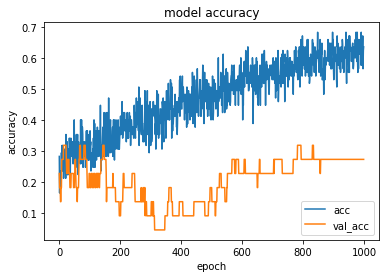

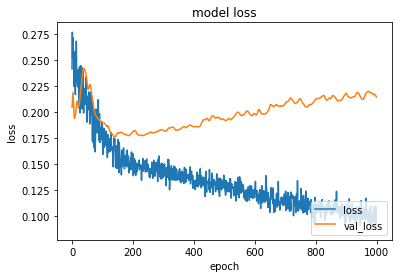

In [173]:
def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

# 学習履歴をプロット
plot_history(history)

## 以下，MLP(回帰問題の場合)

In [174]:
for i in range(len(y)):
    y[i]+=1

#説明変数・目的変数をそれぞれ訓練データ・テストデータに分割
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)


#データの整形
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)

# y_train = keras.utils.to_categorical(y_train,6)
# y_test = keras.utils.to_categorical(y_test,6)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(85, 5) (85,) (22, 5) (22,)


In [175]:
#ニューラルネットワークの実装①
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(len(x.columns),)))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu', input_shape=(len(x.columns),)))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu', input_shape=(len(x.columns),)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='relu'))

model.summary()
print("\n")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 50)                300       
_________________________________________________________________
dropout_64 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_65 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_66 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 51        
Total para

In [176]:
#ニューラルネットワークの実装②
# model.compile(loss='mean_squared_error',optimizer=RMSprop(),metrics=['accuracy'])
#勾配法には、Adam(lr=1e-3)という方法もある（らしい）。
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['mae', 'acc'])

#ニューラルネットワークの学習
history = model.fit(x_train, y_train,batch_size=200,epochs=1000,verbose=1,validation_data=(x_test, y_test))

#ニューラルネットワークの推論
score = model.evaluate(x_test,y_test,verbose=1)
print("\n")
print("Test loss:",score[0])
print("Test accuracy:",score[1])

Train on 85 samples, validate on 22 samples
Epoch 1/1000
85/85 [==============================] - 1s 11ms/step - loss: 10.5474 - mean_absolute_error: 2.9411 - acc: 0.0353 - val_loss: 7.8961 - val_mean_absolute_error: 2.4350 - val_acc: 0.1364
Epoch 2/1000
85/85 [==============================] - 0s 51us/step - loss: 12.0497 - mean_absolute_error: 2.9995 - acc: 0.0235 - val_loss: 8.5684 - val_mean_absolute_error: 2.5828 - val_acc: 0.0000e+00
Epoch 3/1000
85/85 [==============================] - 0s 50us/step - loss: 9.4968 - mean_absolute_error: 2.7419 - acc: 0.0824 - val_loss: 8.4997 - val_mean_absolute_error: 2.5579 - val_acc: 0.0000e+00
Epoch 4/1000
85/85 [==============================] - 0s 51us/step - loss: 12.0202 - mean_absolute_error: 2.9974 - acc: 0.0471 - val_loss: 8.7290 - val_mean_absolute_error: 2.5988 - val_acc: 0.0000e+00
Epoch 5/1000
85/85 [==============================] - 0s 42us/step - loss: 8.9064 - mean_absolute_error: 2.5530 - acc: 0.0588 - val_loss: 8.8735 - val_me

Epoch 43/1000
85/85 [==============================] - 0s 65us/step - loss: 4.3308 - mean_absolute_error: 1.6774 - acc: 0.1647 - val_loss: 2.1768 - val_mean_absolute_error: 1.2906 - val_acc: 0.1818
Epoch 44/1000
85/85 [==============================] - 0s 48us/step - loss: 2.9959 - mean_absolute_error: 1.4298 - acc: 0.1882 - val_loss: 2.1576 - val_mean_absolute_error: 1.2874 - val_acc: 0.1818
Epoch 45/1000
85/85 [==============================] - 0s 36us/step - loss: 4.3922 - mean_absolute_error: 1.7169 - acc: 0.1647 - val_loss: 2.1661 - val_mean_absolute_error: 1.2951 - val_acc: 0.1818
Epoch 46/1000
85/85 [==============================] - 0s 38us/step - loss: 4.1118 - mean_absolute_error: 1.6457 - acc: 0.1647 - val_loss: 2.1785 - val_mean_absolute_error: 1.3028 - val_acc: 0.1818
Epoch 47/1000
85/85 [==============================] - 0s 42us/step - loss: 3.4872 - mean_absolute_error: 1.5187 - acc: 0.1765 - val_loss: 2.2089 - val_mean_absolute_error: 1.3182 - val_acc: 0.1364
Epoch 48/1

Epoch 85/1000
85/85 [==============================] - 0s 52us/step - loss: 2.2837 - mean_absolute_error: 1.1611 - acc: 0.2941 - val_loss: 2.3907 - val_mean_absolute_error: 1.3767 - val_acc: 0.0909
Epoch 86/1000
85/85 [==============================] - 0s 47us/step - loss: 2.0964 - mean_absolute_error: 1.1726 - acc: 0.2941 - val_loss: 2.3539 - val_mean_absolute_error: 1.3654 - val_acc: 0.0909
Epoch 87/1000
85/85 [==============================] - 0s 51us/step - loss: 3.0271 - mean_absolute_error: 1.3757 - acc: 0.2824 - val_loss: 2.3328 - val_mean_absolute_error: 1.3586 - val_acc: 0.0909
Epoch 88/1000
85/85 [==============================] - 0s 54us/step - loss: 2.3546 - mean_absolute_error: 1.2118 - acc: 0.2824 - val_loss: 2.3147 - val_mean_absolute_error: 1.3525 - val_acc: 0.0909
Epoch 89/1000
85/85 [==============================] - 0s 61us/step - loss: 2.1267 - mean_absolute_error: 1.2442 - acc: 0.2000 - val_loss: 2.3036 - val_mean_absolute_error: 1.3486 - val_acc: 0.1364
Epoch 90/1

Epoch 127/1000
85/85 [==============================] - 0s 53us/step - loss: 1.8513 - mean_absolute_error: 1.1120 - acc: 0.2941 - val_loss: 2.2515 - val_mean_absolute_error: 1.3190 - val_acc: 0.1818
Epoch 128/1000
85/85 [==============================] - 0s 47us/step - loss: 2.1457 - mean_absolute_error: 1.1536 - acc: 0.2588 - val_loss: 2.2611 - val_mean_absolute_error: 1.3220 - val_acc: 0.1818
Epoch 129/1000
85/85 [==============================] - 0s 54us/step - loss: 2.4170 - mean_absolute_error: 1.2225 - acc: 0.2941 - val_loss: 2.2791 - val_mean_absolute_error: 1.3275 - val_acc: 0.1818
Epoch 130/1000
85/85 [==============================] - 0s 49us/step - loss: 2.8291 - mean_absolute_error: 1.2981 - acc: 0.2706 - val_loss: 2.2857 - val_mean_absolute_error: 1.3292 - val_acc: 0.1818
Epoch 131/1000
85/85 [==============================] - 0s 57us/step - loss: 1.9440 - mean_absolute_error: 1.1509 - acc: 0.2118 - val_loss: 2.2865 - val_mean_absolute_error: 1.3291 - val_acc: 0.1364
Epoch

Epoch 169/1000
85/85 [==============================] - 0s 50us/step - loss: 2.2246 - mean_absolute_error: 1.2314 - acc: 0.2235 - val_loss: 2.3032 - val_mean_absolute_error: 1.3319 - val_acc: 0.0909
Epoch 170/1000
85/85 [==============================] - 0s 48us/step - loss: 2.0643 - mean_absolute_error: 1.1794 - acc: 0.2118 - val_loss: 2.2615 - val_mean_absolute_error: 1.3199 - val_acc: 0.0909
Epoch 171/1000
85/85 [==============================] - 0s 64us/step - loss: 1.5709 - mean_absolute_error: 1.0091 - acc: 0.2824 - val_loss: 2.2114 - val_mean_absolute_error: 1.3049 - val_acc: 0.1364
Epoch 172/1000
85/85 [==============================] - 0s 56us/step - loss: 1.7794 - mean_absolute_error: 1.1141 - acc: 0.2588 - val_loss: 2.1718 - val_mean_absolute_error: 1.2927 - val_acc: 0.1818
Epoch 173/1000
85/85 [==============================] - 0s 58us/step - loss: 2.0687 - mean_absolute_error: 1.1918 - acc: 0.2706 - val_loss: 2.1391 - val_mean_absolute_error: 1.2820 - val_acc: 0.1818
Epoch

Epoch 211/1000
85/85 [==============================] - 0s 44us/step - loss: 1.8777 - mean_absolute_error: 1.1231 - acc: 0.1882 - val_loss: 2.2852 - val_mean_absolute_error: 1.3209 - val_acc: 0.1818
Epoch 212/1000
85/85 [==============================] - 0s 46us/step - loss: 1.5713 - mean_absolute_error: 1.0275 - acc: 0.2941 - val_loss: 2.2748 - val_mean_absolute_error: 1.3176 - val_acc: 0.1818
Epoch 213/1000
85/85 [==============================] - 0s 48us/step - loss: 2.0780 - mean_absolute_error: 1.1736 - acc: 0.2235 - val_loss: 2.2833 - val_mean_absolute_error: 1.3207 - val_acc: 0.1818
Epoch 214/1000
85/85 [==============================] - 0s 48us/step - loss: 1.5683 - mean_absolute_error: 1.0284 - acc: 0.2706 - val_loss: 2.2895 - val_mean_absolute_error: 1.3228 - val_acc: 0.1818
Epoch 215/1000
85/85 [==============================] - 0s 50us/step - loss: 1.6996 - mean_absolute_error: 1.0316 - acc: 0.3529 - val_loss: 2.2958 - val_mean_absolute_error: 1.3247 - val_acc: 0.1364
Epoch

Epoch 253/1000
85/85 [==============================] - 0s 46us/step - loss: 1.4879 - mean_absolute_error: 0.9430 - acc: 0.3529 - val_loss: 2.2652 - val_mean_absolute_error: 1.3092 - val_acc: 0.0909
Epoch 254/1000
85/85 [==============================] - 0s 55us/step - loss: 1.9086 - mean_absolute_error: 1.1096 - acc: 0.2824 - val_loss: 2.2505 - val_mean_absolute_error: 1.3043 - val_acc: 0.0909
Epoch 255/1000
85/85 [==============================] - 0s 56us/step - loss: 1.9427 - mean_absolute_error: 1.0994 - acc: 0.2941 - val_loss: 2.2480 - val_mean_absolute_error: 1.3039 - val_acc: 0.0909
Epoch 256/1000
85/85 [==============================] - 0s 48us/step - loss: 1.6156 - mean_absolute_error: 1.0117 - acc: 0.3294 - val_loss: 2.2511 - val_mean_absolute_error: 1.3055 - val_acc: 0.0909
Epoch 257/1000
85/85 [==============================] - 0s 52us/step - loss: 1.5212 - mean_absolute_error: 0.9804 - acc: 0.3294 - val_loss: 2.2612 - val_mean_absolute_error: 1.3098 - val_acc: 0.1364
Epoch

Epoch 295/1000
85/85 [==============================] - 0s 61us/step - loss: 1.2981 - mean_absolute_error: 0.9426 - acc: 0.2824 - val_loss: 2.4930 - val_mean_absolute_error: 1.3639 - val_acc: 0.1818
Epoch 296/1000
85/85 [==============================] - 0s 61us/step - loss: 1.4666 - mean_absolute_error: 0.9556 - acc: 0.3059 - val_loss: 2.4823 - val_mean_absolute_error: 1.3608 - val_acc: 0.1818
Epoch 297/1000
85/85 [==============================] - 0s 50us/step - loss: 1.5724 - mean_absolute_error: 1.0048 - acc: 0.3294 - val_loss: 2.4613 - val_mean_absolute_error: 1.3553 - val_acc: 0.1818
Epoch 298/1000
85/85 [==============================] - 0s 54us/step - loss: 1.9155 - mean_absolute_error: 1.1482 - acc: 0.2588 - val_loss: 2.4542 - val_mean_absolute_error: 1.3532 - val_acc: 0.1818
Epoch 299/1000
85/85 [==============================] - 0s 60us/step - loss: 1.2955 - mean_absolute_error: 0.9231 - acc: 0.3412 - val_loss: 2.4493 - val_mean_absolute_error: 1.3515 - val_acc: 0.1364
Epoch

Epoch 337/1000
85/85 [==============================] - 0s 42us/step - loss: 1.2824 - mean_absolute_error: 0.9348 - acc: 0.2706 - val_loss: 2.6549 - val_mean_absolute_error: 1.3980 - val_acc: 0.1364
Epoch 338/1000
85/85 [==============================] - 0s 45us/step - loss: 1.5207 - mean_absolute_error: 0.9702 - acc: 0.3412 - val_loss: 2.6670 - val_mean_absolute_error: 1.4003 - val_acc: 0.1364
Epoch 339/1000
85/85 [==============================] - 0s 52us/step - loss: 1.3392 - mean_absolute_error: 0.9317 - acc: 0.3765 - val_loss: 2.6620 - val_mean_absolute_error: 1.3975 - val_acc: 0.1364
Epoch 340/1000
85/85 [==============================] - 0s 55us/step - loss: 1.5202 - mean_absolute_error: 0.9797 - acc: 0.3647 - val_loss: 2.6584 - val_mean_absolute_error: 1.3953 - val_acc: 0.1364
Epoch 341/1000
85/85 [==============================] - 0s 54us/step - loss: 1.7446 - mean_absolute_error: 1.0192 - acc: 0.3176 - val_loss: 2.6432 - val_mean_absolute_error: 1.3900 - val_acc: 0.1364
Epoch

Epoch 379/1000
85/85 [==============================] - 0s 56us/step - loss: 1.6229 - mean_absolute_error: 1.0475 - acc: 0.3059 - val_loss: 2.4637 - val_mean_absolute_error: 1.3510 - val_acc: 0.1364
Epoch 380/1000
85/85 [==============================] - 0s 50us/step - loss: 1.5852 - mean_absolute_error: 1.0181 - acc: 0.2824 - val_loss: 2.4658 - val_mean_absolute_error: 1.3521 - val_acc: 0.1364
Epoch 381/1000
85/85 [==============================] - 0s 52us/step - loss: 1.2696 - mean_absolute_error: 0.8458 - acc: 0.4588 - val_loss: 2.4740 - val_mean_absolute_error: 1.3548 - val_acc: 0.1364
Epoch 382/1000
85/85 [==============================] - 0s 54us/step - loss: 1.1326 - mean_absolute_error: 0.8512 - acc: 0.3882 - val_loss: 2.4807 - val_mean_absolute_error: 1.3568 - val_acc: 0.1364
Epoch 383/1000
85/85 [==============================] - 0s 57us/step - loss: 1.2166 - mean_absolute_error: 0.8955 - acc: 0.3882 - val_loss: 2.4751 - val_mean_absolute_error: 1.3555 - val_acc: 0.1364
Epoch

Epoch 421/1000
85/85 [==============================] - 0s 50us/step - loss: 1.2067 - mean_absolute_error: 0.9038 - acc: 0.2824 - val_loss: 2.5626 - val_mean_absolute_error: 1.3828 - val_acc: 0.1364
Epoch 422/1000
85/85 [==============================] - 0s 56us/step - loss: 1.5479 - mean_absolute_error: 1.0354 - acc: 0.2706 - val_loss: 2.5674 - val_mean_absolute_error: 1.3834 - val_acc: 0.1364
Epoch 423/1000
85/85 [==============================] - 0s 54us/step - loss: 1.4061 - mean_absolute_error: 0.9432 - acc: 0.3294 - val_loss: 2.5644 - val_mean_absolute_error: 1.3820 - val_acc: 0.1364
Epoch 424/1000
85/85 [==============================] - 0s 62us/step - loss: 1.5230 - mean_absolute_error: 1.0426 - acc: 0.2588 - val_loss: 2.5541 - val_mean_absolute_error: 1.3793 - val_acc: 0.1364
Epoch 425/1000
85/85 [==============================] - 0s 59us/step - loss: 1.0549 - mean_absolute_error: 0.8171 - acc: 0.3647 - val_loss: 2.5249 - val_mean_absolute_error: 1.3718 - val_acc: 0.1364
Epoch

Epoch 463/1000
85/85 [==============================] - 0s 48us/step - loss: 1.2115 - mean_absolute_error: 0.9277 - acc: 0.2706 - val_loss: 2.5977 - val_mean_absolute_error: 1.3912 - val_acc: 0.1364
Epoch 464/1000
85/85 [==============================] - 0s 37us/step - loss: 1.0557 - mean_absolute_error: 0.8201 - acc: 0.3412 - val_loss: 2.5989 - val_mean_absolute_error: 1.3914 - val_acc: 0.1364
Epoch 465/1000
85/85 [==============================] - 0s 37us/step - loss: 1.6628 - mean_absolute_error: 1.0392 - acc: 0.2353 - val_loss: 2.6003 - val_mean_absolute_error: 1.3915 - val_acc: 0.1364
Epoch 466/1000
85/85 [==============================] - 0s 44us/step - loss: 0.9641 - mean_absolute_error: 0.7895 - acc: 0.4000 - val_loss: 2.5877 - val_mean_absolute_error: 1.3880 - val_acc: 0.1364
Epoch 467/1000
85/85 [==============================] - 0s 44us/step - loss: 1.2146 - mean_absolute_error: 0.8940 - acc: 0.3647 - val_loss: 2.5713 - val_mean_absolute_error: 1.3834 - val_acc: 0.1364
Epoch

Epoch 505/1000
85/85 [==============================] - 0s 59us/step - loss: 0.9939 - mean_absolute_error: 0.7937 - acc: 0.4000 - val_loss: 2.5450 - val_mean_absolute_error: 1.3733 - val_acc: 0.1364
Epoch 506/1000
85/85 [==============================] - 0s 107us/step - loss: 1.1443 - mean_absolute_error: 0.8278 - acc: 0.3882 - val_loss: 2.5372 - val_mean_absolute_error: 1.3709 - val_acc: 0.1364
Epoch 507/1000
85/85 [==============================] - 0s 45us/step - loss: 1.5236 - mean_absolute_error: 0.9879 - acc: 0.3294 - val_loss: 2.5336 - val_mean_absolute_error: 1.3694 - val_acc: 0.1364
Epoch 508/1000
85/85 [==============================] - 0s 42us/step - loss: 1.4481 - mean_absolute_error: 0.9372 - acc: 0.3529 - val_loss: 2.5374 - val_mean_absolute_error: 1.3705 - val_acc: 0.1364
Epoch 509/1000
85/85 [==============================] - 0s 45us/step - loss: 1.3033 - mean_absolute_error: 0.9049 - acc: 0.3529 - val_loss: 2.5511 - val_mean_absolute_error: 1.3741 - val_acc: 0.1364
Epoc

Epoch 547/1000
85/85 [==============================] - 0s 58us/step - loss: 1.2431 - mean_absolute_error: 0.8736 - acc: 0.2941 - val_loss: 2.6359 - val_mean_absolute_error: 1.3892 - val_acc: 0.1364
Epoch 548/1000
85/85 [==============================] - 0s 61us/step - loss: 1.2773 - mean_absolute_error: 0.9313 - acc: 0.3176 - val_loss: 2.6343 - val_mean_absolute_error: 1.3889 - val_acc: 0.1364
Epoch 549/1000
85/85 [==============================] - 0s 61us/step - loss: 1.4558 - mean_absolute_error: 0.9748 - acc: 0.3294 - val_loss: 2.6389 - val_mean_absolute_error: 1.3904 - val_acc: 0.1364
Epoch 550/1000
85/85 [==============================] - 0s 50us/step - loss: 1.2380 - mean_absolute_error: 0.8397 - acc: 0.4353 - val_loss: 2.6455 - val_mean_absolute_error: 1.3925 - val_acc: 0.1364
Epoch 551/1000
85/85 [==============================] - 0s 46us/step - loss: 1.2568 - mean_absolute_error: 0.8624 - acc: 0.4118 - val_loss: 2.6522 - val_mean_absolute_error: 1.3946 - val_acc: 0.1364
Epoch

Epoch 589/1000
85/85 [==============================] - 0s 64us/step - loss: 1.0512 - mean_absolute_error: 0.8609 - acc: 0.2941 - val_loss: 2.6556 - val_mean_absolute_error: 1.3985 - val_acc: 0.0909
Epoch 590/1000
85/85 [==============================] - 0s 48us/step - loss: 1.2513 - mean_absolute_error: 0.9384 - acc: 0.2941 - val_loss: 2.6549 - val_mean_absolute_error: 1.3985 - val_acc: 0.0909
Epoch 591/1000
85/85 [==============================] - 0s 47us/step - loss: 1.1807 - mean_absolute_error: 0.8316 - acc: 0.4353 - val_loss: 2.6527 - val_mean_absolute_error: 1.3983 - val_acc: 0.0909
Epoch 592/1000
85/85 [==============================] - 0s 53us/step - loss: 1.0829 - mean_absolute_error: 0.8175 - acc: 0.4000 - val_loss: 2.6560 - val_mean_absolute_error: 1.3996 - val_acc: 0.0909
Epoch 593/1000
85/85 [==============================] - 0s 50us/step - loss: 1.2600 - mean_absolute_error: 0.9229 - acc: 0.3176 - val_loss: 2.6514 - val_mean_absolute_error: 1.3987 - val_acc: 0.0909
Epoch

Epoch 631/1000
85/85 [==============================] - 0s 59us/step - loss: 1.1551 - mean_absolute_error: 0.8325 - acc: 0.4235 - val_loss: 2.6220 - val_mean_absolute_error: 1.3843 - val_acc: 0.0909
Epoch 632/1000
85/85 [==============================] - 0s 54us/step - loss: 1.4964 - mean_absolute_error: 0.9641 - acc: 0.3647 - val_loss: 2.6392 - val_mean_absolute_error: 1.3898 - val_acc: 0.1364
Epoch 633/1000
85/85 [==============================] - 0s 57us/step - loss: 1.1879 - mean_absolute_error: 0.8632 - acc: 0.4118 - val_loss: 2.6598 - val_mean_absolute_error: 1.3963 - val_acc: 0.1364
Epoch 634/1000
85/85 [==============================] - 0s 56us/step - loss: 1.0922 - mean_absolute_error: 0.8759 - acc: 0.2824 - val_loss: 2.6806 - val_mean_absolute_error: 1.4028 - val_acc: 0.1364
Epoch 635/1000
85/85 [==============================] - 0s 57us/step - loss: 1.1106 - mean_absolute_error: 0.8874 - acc: 0.2941 - val_loss: 2.6942 - val_mean_absolute_error: 1.4071 - val_acc: 0.1364
Epoch

Epoch 673/1000
85/85 [==============================] - 0s 52us/step - loss: 1.1780 - mean_absolute_error: 0.8652 - acc: 0.4118 - val_loss: 2.6663 - val_mean_absolute_error: 1.4004 - val_acc: 0.0909
Epoch 674/1000
85/85 [==============================] - 0s 52us/step - loss: 1.3427 - mean_absolute_error: 0.9509 - acc: 0.3176 - val_loss: 2.6761 - val_mean_absolute_error: 1.4034 - val_acc: 0.0909
Epoch 675/1000
85/85 [==============================] - 0s 54us/step - loss: 1.0795 - mean_absolute_error: 0.8299 - acc: 0.3882 - val_loss: 2.6826 - val_mean_absolute_error: 1.4054 - val_acc: 0.0909
Epoch 676/1000
85/85 [==============================] - 0s 51us/step - loss: 1.2807 - mean_absolute_error: 0.9483 - acc: 0.2706 - val_loss: 2.6899 - val_mean_absolute_error: 1.4076 - val_acc: 0.0909
Epoch 677/1000
85/85 [==============================] - 0s 51us/step - loss: 1.0582 - mean_absolute_error: 0.8370 - acc: 0.3882 - val_loss: 2.6884 - val_mean_absolute_error: 1.4073 - val_acc: 0.0909
Epoch

Epoch 715/1000
85/85 [==============================] - 0s 51us/step - loss: 1.1459 - mean_absolute_error: 0.8628 - acc: 0.3529 - val_loss: 2.6078 - val_mean_absolute_error: 1.3836 - val_acc: 0.0909
Epoch 716/1000
85/85 [==============================] - 0s 58us/step - loss: 1.3021 - mean_absolute_error: 0.9007 - acc: 0.3294 - val_loss: 2.6075 - val_mean_absolute_error: 1.3827 - val_acc: 0.0909
Epoch 717/1000
85/85 [==============================] - 0s 53us/step - loss: 1.1754 - mean_absolute_error: 0.8660 - acc: 0.3765 - val_loss: 2.6121 - val_mean_absolute_error: 1.3835 - val_acc: 0.0909
Epoch 718/1000
85/85 [==============================] - 0s 50us/step - loss: 1.3662 - mean_absolute_error: 0.9478 - acc: 0.3647 - val_loss: 2.6135 - val_mean_absolute_error: 1.3833 - val_acc: 0.0909
Epoch 719/1000
85/85 [==============================] - 0s 66us/step - loss: 1.2466 - mean_absolute_error: 0.8809 - acc: 0.4118 - val_loss: 2.6142 - val_mean_absolute_error: 1.3828 - val_acc: 0.0909
Epoch

Epoch 757/1000
85/85 [==============================] - 0s 48us/step - loss: 1.2378 - mean_absolute_error: 0.8853 - acc: 0.4118 - val_loss: 2.5629 - val_mean_absolute_error: 1.3627 - val_acc: 0.0909
Epoch 758/1000
85/85 [==============================] - 0s 42us/step - loss: 1.2245 - mean_absolute_error: 0.8926 - acc: 0.3647 - val_loss: 2.5803 - val_mean_absolute_error: 1.3692 - val_acc: 0.0909
Epoch 759/1000
85/85 [==============================] - 0s 40us/step - loss: 1.0637 - mean_absolute_error: 0.8599 - acc: 0.2941 - val_loss: 2.5892 - val_mean_absolute_error: 1.3724 - val_acc: 0.0909
Epoch 760/1000
85/85 [==============================] - 0s 50us/step - loss: 1.1055 - mean_absolute_error: 0.8556 - acc: 0.3529 - val_loss: 2.5985 - val_mean_absolute_error: 1.3757 - val_acc: 0.0909
Epoch 761/1000
85/85 [==============================] - 0s 58us/step - loss: 1.0388 - mean_absolute_error: 0.8234 - acc: 0.3765 - val_loss: 2.6126 - val_mean_absolute_error: 1.3809 - val_acc: 0.0909
Epoch

Epoch 799/1000
85/85 [==============================] - 0s 50us/step - loss: 1.1678 - mean_absolute_error: 0.8623 - acc: 0.4000 - val_loss: 2.5999 - val_mean_absolute_error: 1.3713 - val_acc: 0.0909
Epoch 800/1000
85/85 [==============================] - 0s 45us/step - loss: 1.0999 - mean_absolute_error: 0.7919 - acc: 0.4588 - val_loss: 2.6067 - val_mean_absolute_error: 1.3747 - val_acc: 0.0909
Epoch 801/1000
85/85 [==============================] - 0s 51us/step - loss: 1.2925 - mean_absolute_error: 0.9098 - acc: 0.4000 - val_loss: 2.6075 - val_mean_absolute_error: 1.3756 - val_acc: 0.0909
Epoch 802/1000
85/85 [==============================] - 0s 62us/step - loss: 0.9268 - mean_absolute_error: 0.7715 - acc: 0.3882 - val_loss: 2.5970 - val_mean_absolute_error: 1.3718 - val_acc: 0.0909
Epoch 803/1000
85/85 [==============================] - 0s 56us/step - loss: 1.1912 - mean_absolute_error: 0.8632 - acc: 0.4000 - val_loss: 2.5882 - val_mean_absolute_error: 1.3689 - val_acc: 0.0909
Epoch

Epoch 841/1000
85/85 [==============================] - 0s 58us/step - loss: 1.0683 - mean_absolute_error: 0.8607 - acc: 0.2941 - val_loss: 2.5512 - val_mean_absolute_error: 1.3688 - val_acc: 0.0909
Epoch 842/1000
85/85 [==============================] - 0s 51us/step - loss: 1.1578 - mean_absolute_error: 0.9143 - acc: 0.2353 - val_loss: 2.5621 - val_mean_absolute_error: 1.3729 - val_acc: 0.0909
Epoch 843/1000
85/85 [==============================] - 0s 66us/step - loss: 1.0873 - mean_absolute_error: 0.8176 - acc: 0.4235 - val_loss: 2.5687 - val_mean_absolute_error: 1.3750 - val_acc: 0.0909
Epoch 844/1000
85/85 [==============================] - 0s 61us/step - loss: 1.0804 - mean_absolute_error: 0.8303 - acc: 0.3765 - val_loss: 2.5772 - val_mean_absolute_error: 1.3780 - val_acc: 0.0909
Epoch 845/1000
85/85 [==============================] - 0s 72us/step - loss: 1.3575 - mean_absolute_error: 0.9040 - acc: 0.4118 - val_loss: 2.5863 - val_mean_absolute_error: 1.3810 - val_acc: 0.0909
Epoch

Epoch 883/1000
85/85 [==============================] - 0s 37us/step - loss: 0.9790 - mean_absolute_error: 0.7834 - acc: 0.4353 - val_loss: 2.5962 - val_mean_absolute_error: 1.3637 - val_acc: 0.1364
Epoch 884/1000
85/85 [==============================] - 0s 38us/step - loss: 1.0112 - mean_absolute_error: 0.8172 - acc: 0.3412 - val_loss: 2.6013 - val_mean_absolute_error: 1.3645 - val_acc: 0.1364
Epoch 885/1000
85/85 [==============================] - 0s 44us/step - loss: 1.0529 - mean_absolute_error: 0.7973 - acc: 0.4000 - val_loss: 2.6046 - val_mean_absolute_error: 1.3645 - val_acc: 0.1364
Epoch 886/1000
85/85 [==============================] - 0s 48us/step - loss: 0.9717 - mean_absolute_error: 0.7835 - acc: 0.4118 - val_loss: 2.6036 - val_mean_absolute_error: 1.3631 - val_acc: 0.1364
Epoch 887/1000
85/85 [==============================] - 0s 44us/step - loss: 1.2985 - mean_absolute_error: 0.8668 - acc: 0.3882 - val_loss: 2.6072 - val_mean_absolute_error: 1.3639 - val_acc: 0.1364
Epoch

Epoch 925/1000
85/85 [==============================] - 0s 57us/step - loss: 0.9224 - mean_absolute_error: 0.7942 - acc: 0.3412 - val_loss: 2.6465 - val_mean_absolute_error: 1.3946 - val_acc: 0.1364
Epoch 926/1000
85/85 [==============================] - 0s 61us/step - loss: 1.0824 - mean_absolute_error: 0.8374 - acc: 0.3529 - val_loss: 2.6449 - val_mean_absolute_error: 1.3934 - val_acc: 0.1364
Epoch 927/1000
85/85 [==============================] - 0s 60us/step - loss: 1.1520 - mean_absolute_error: 0.8649 - acc: 0.3765 - val_loss: 2.6459 - val_mean_absolute_error: 1.3928 - val_acc: 0.1364
Epoch 928/1000
85/85 [==============================] - 0s 58us/step - loss: 0.8013 - mean_absolute_error: 0.7351 - acc: 0.3765 - val_loss: 2.6458 - val_mean_absolute_error: 1.3916 - val_acc: 0.1364
Epoch 929/1000
85/85 [==============================] - 0s 51us/step - loss: 0.9179 - mean_absolute_error: 0.7603 - acc: 0.4471 - val_loss: 2.6428 - val_mean_absolute_error: 1.3888 - val_acc: 0.1364
Epoch

Epoch 967/1000
85/85 [==============================] - 0s 68us/step - loss: 1.1104 - mean_absolute_error: 0.8289 - acc: 0.4000 - val_loss: 2.6819 - val_mean_absolute_error: 1.4005 - val_acc: 0.0909
Epoch 968/1000
85/85 [==============================] - 0s 62us/step - loss: 0.9428 - mean_absolute_error: 0.7485 - acc: 0.4353 - val_loss: 2.6946 - val_mean_absolute_error: 1.4054 - val_acc: 0.0909
Epoch 969/1000
85/85 [==============================] - 0s 63us/step - loss: 1.1306 - mean_absolute_error: 0.8240 - acc: 0.3647 - val_loss: 2.7002 - val_mean_absolute_error: 1.4072 - val_acc: 0.1364
Epoch 970/1000
85/85 [==============================] - 0s 66us/step - loss: 1.1949 - mean_absolute_error: 0.8472 - acc: 0.4118 - val_loss: 2.6971 - val_mean_absolute_error: 1.4056 - val_acc: 0.1364
Epoch 971/1000
85/85 [==============================] - 0s 60us/step - loss: 1.1778 - mean_absolute_error: 0.8431 - acc: 0.3412 - val_loss: 2.6997 - val_mean_absolute_error: 1.4060 - val_acc: 0.1364
Epoch

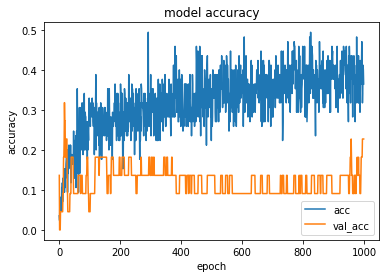

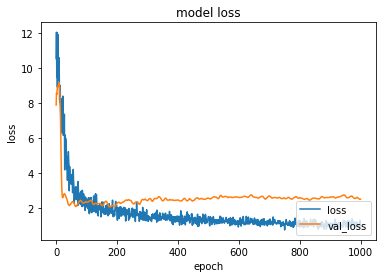

In [177]:
def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

# 学習履歴をプロット
plot_history(history)